In [1]:
# testing warm_start adding estimators- manually stop at 5 batches

from train_generic_model_standalone import ex

ex.run()


WARNING - Q1 - No observers have been added to this run
INFO - Q1 - Running command 'main'
INFO - Q1 - Started
INFO - train_generic_model_standalone -  Load Xarray batch 0: 
INFO - train_generic_model_standalone - Wrote batch to ../../data/processed/generic_model_format/batch_data_0
INFO - train_generic_model_standalone - training batch 0 / 32
INFO - train_generic_model_standalone - Completed training on batch 0
INFO - train_generic_model_standalone -  Load Xarray batch 1: 
INFO - train_generic_model_standalone - Wrote batch to ../../data/processed/generic_model_format/batch_data_1
INFO - train_generic_model_standalone - training batch 1 / 32
INFO - train_generic_model_standalone - Completed training on batch 1
INFO - train_generic_model_standalone -  Load Xarray batch 2: 
INFO - train_generic_model_standalone - Wrote batch to ../../data/processed/generic_model_format/batch_data_2
INFO - train_generic_model_standalone - training batch 2 / 32
INFO - train_generic_model_standalone - Comp

In [67]:
import joblib
import numpy as np

rf_model = joblib.load('rf_regressor.pkl')

test_data = np.load('test_data_with_y_coord.npy')
test_data = test_data[~np.isnan(test_data).any(axis=1)]
y_coords = test_data[:, 0]

# num target variables (Q1, Q2) x num z layers
num_target_columns = num_target_columns = int((np.shape(test_data)[1] - 2) / 2)
test_data_features = test_data[:, 1:-num_target_columns] 
test_data_targets = test_data[:,-num_target_columns:] 

z_layer_mass = np.load('z_layer_mass.npy')
z_levels = np.load('z_levels.npy')
assert(len(z_layer_mass)==np.shape(test_data_targets)[1]/2)

pred_targets = rf_model.predict(test_data_features)

mass_weight_vector = get_mass_weight_vector(
    z_layer_mass, 
    num_target_vars=1)


In [85]:
def get_y_coord_total_sum_squares(y_coords, values):
    """
    y coord array is not unique, corresponds to y coordinate of each elem in values
    return dict of {y coord: [SST for each var, z]}
    """
    y_coord_groupings = {}
    for y, value in zip(y_coords, values):
        if y in y_coord_groupings:
            y_coord_groupings[y].append(value)
        else:
            y_coord_groupings[y] = [value]
    y_coord_mean = {
        y: np.mean(values_at_y, axis=0)
           for y, values_at_y in y_coord_groupings.items()
    }
    y_coord_total_sum_squares = {
        y: np.sum( (y_coord_groupings[y] - y_coord_mean[y])**2 , axis=0)
            for y in y_coord_mean.keys()
    }
    return y_coord_total_sum_squares

def get_residual_sum_squares(y_coords, values_actual, values_pred):
    y_residual_sum_squares = {}
    for y, obs, pred in zip(y_coords, values_actual, values_pred):
        if y in y_residual_sum_squares:
            y_residual_sum_squares[y] += (obs-pred)**2
        else:
            y_residual_sum_squares[y] = (obs-pred)**2
            
    return y_residual_sum_squares

def get_z_level_r2(
        SSR, 
        SST, 
        z_levels
):
    num_z_layers= len(z_levels)
    r2_at_y_z = []
    for y in SSR.keys():
        z_SSR_Q1 = SSR[y][:num_z_layers]
        z_SSR_Q2 = SSR[y][num_z_layers:]
        z_SST_Q1 = SST[y][:num_z_layers]
        z_SST_Q2 = SST[y][num_z_layers:]
        Q1_r2_at_y_z = 1.- z_SSR_Q1/z_SST_Q1
        Q2_r2_at_y_z = 1.- z_SSR_Q2/z_SST_Q2

        r2_at_y_z.append([y, list(Q1_r2_at_y_z), list(Q2_r2_at_y_z)])
    return r2_at_y_z
        
def pressure_at_z(
        z, # [km]
        p0=1013.25, # p at surface [mbar] 
        H=7.2 # scale height [km]
):
    return p0 * np.exp(-z/H)

def get_mass_weight_vector(
        z_layer_mass, 
        num_target_vars=2
):
    mass_sum = np.sum(z_layer_mass)
    z_layer_mass_normed = z_layer_mass/mass_sum
    mass_weight_vector = z_layer_mass_normed
    for target_var in range(num_target_vars-1):
        mass_weight_vector = np.append(mass_weight_vector, z_layer_mass_normed)
    return mass_weight_vector 

In [87]:
SSR = get_residual_sum_squares(y_coords, test_data_targets, pred_targets)
SST = get_y_coord_total_sum_squares(y_coords, test_data_targets)

z_levels = np.load('z_levels.npy')
r2_at_y_z = get_z_level_r2(
        SSR, 
        SST, 
        z_levels)
r2_at_y_z.sort() # defaults to sort by y (1st col)

Y, Z, R2_Q1, R2_Q2 = [], [], [], []
for y_ind, y in enumerate(sorted(np.unique(y_coords))):
    R2_Q1.append(r2_at_y_z[y_ind][1])
    R2_Q2.append(r2_at_y_z[y_ind][2])


Text(0.5, 1.0, 'Q1')

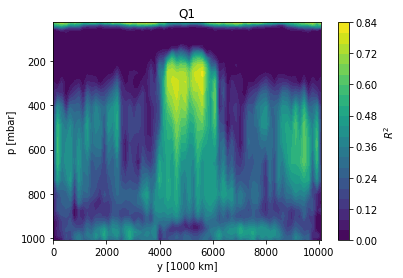

In [227]:
R2_Q1 = np.array(R2_Q1)
R2_Q1[R2_Q1<0] = 0

plt.contourf(
    np.array(sorted(np.unique(y_coords)))/1e3, 
    pressure_at_z(z_levels/1000.), 
    np.array(R2_Q1).T, 
    20, 
    )
plt.gca().invert_yaxis()
plt.xlabel('y [1000 km]')
plt.ylabel('p [mbar]')
plt.colorbar(label='$R^2$')
plt.title('Q1')

Text(0.5, 1.0, 'Q2')

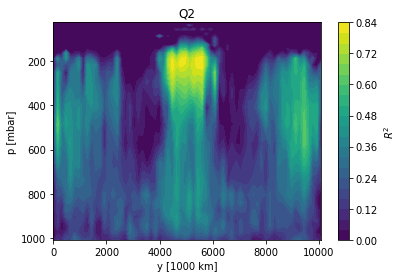

In [226]:
R2_Q2 = np.array(R2_Q2)
q2_nan_ind = np.isnan(R2_Q2)
R2_Q2[q2_nan_ind] = 0
R2_Q2[R2_Q2<0] = 0
plt.contourf(
    np.array(sorted(np.unique(y_coords)))/1e3, 
    pressure_at_z(z_levels/1000.), 
    np.array(R2_Q2).T, 
    20, )
plt.gca().invert_yaxis()
plt.xlabel('y [1000 km]')
plt.ylabel('p [mbar]')
plt.colorbar(label='$R^2$')
plt.title('Q2')